In [1]:
#read ECCC RS41
from bs4 import BeautifulSoup 
from datetime import datetime
import numpy as np

from metpy.units import units

import matplotlib.pyplot as plt

import metpy.calc as mpcalc
from metpy.plots import SkewT, Hodograph

In [6]:
def smooth(y, box_pts):
    #box = np.ones(box_pts)/box_pts
    #y_smooth = np.convolve(y, box, mode='same')
    y_smooth = scipy.ndimage.uniform_filter1d(y, box_pts, mode='nearest')
    return y_smooth


In [7]:
snd_ffn = '/g/data/kl02/jss548/hail-research/hailsonde/20230723_stony_plain_sondes/stony_plain_exp_ua_20230723_231518.xml'
with open(snd_ffn, 'r') as f:
    data = f.read() 

# Passing the stored data inside the beautifulsoup parser 
bs_data = BeautifulSoup(data, "lxml") 
ec_dt_list = []
ec_dts_list = []
ec_rh_list = []
ec_hght_list = []
ec_pres_list = []
ec_temp_list = []
ec_wdir_list = []
ec_wspd_list = []
for row in bs_data.find_all('row'):
    ec_dt_list.append(datetime.strptime(row.get('datasrvtime')[:-3],'%Y-%m-%dT%H:%M:%S.%f')) #python datetime
    ec_dts_list.append(row.get('datasrvtime')) #datetime string
    ec_hght_list.append(float(row.get('altitude'))) #m AMSL
    ec_rh_list.append(float(row.get('humidity'))) #RH
    ec_pres_list.append(float(row.get('pressure'))) #pressure hpa
    ec_temp_list.append(float(row.get('temperature'))) #K
    ec_wdir_list.append(float(row.get('winddir'))) #degTN
    ec_wspd_list.append(float(row.get('windspeed'))) #m/s

ec_rh_array = np.array(ec_rh_list)[1:]  * units.percent
ec_hght_array = np.array(ec_hght_list)[1:] * units.meters
ec_pres_array = np.array(ec_pres_list)[1:] * units.hPa
ec_temp_array = (np.array(ec_temp_list)[1:] - 273.15) * units.degC
ec_wdir_array = np.array(ec_wdir_list)[1:] * units.degrees
ec_wspd_array = np.array(ec_wspd_list)[1:] * units('m/s')

ec_u_array, ec_v_array = mpcalc.wind_components(ec_wspd_array, ec_wdir_array)
ec_dwpt_array = mpcalc.dewpoint_from_relative_humidity(ec_temp_array, ec_rh_array)




In [8]:
p_min = 150
p_max = 950
t_min = -30
t_max = 40

mucape 1815.6655372253322 joule / kilogram
mucin -60.902861815014056 joule / kilogram
mlcape 1297.7251888302692 joule / kilogram
mlcin -98.70584713519428 joule / kilogram
sbcape 1815.6655372253322 joule / kilogram
sbcin -60.902861815014056 joule / kilogram
bshear6 38.5160584254387 meter / second knots


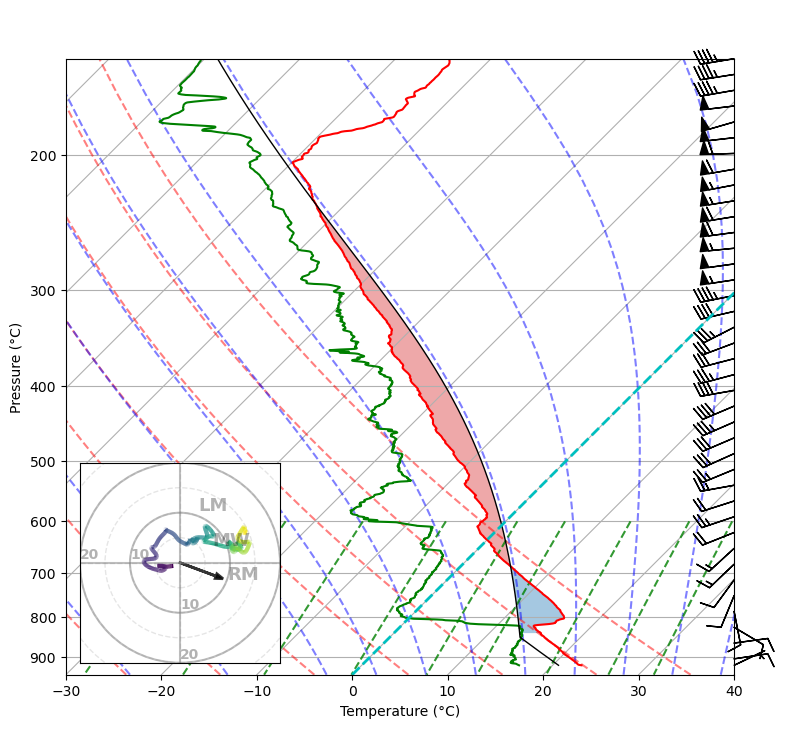

In [12]:
fig = plt.figure(figsize=(16, 8))
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.
skew.plot(ec_pres_array, ec_temp_array, 'r')
skew.plot(ec_pres_array, ec_dwpt_array, 'g')

interval = np.logspace(np.log10(p_min), np.log10(p_max), 40) * units.hPa
idx = mpcalc.resample_nn_1d(ec_pres_array, interval)
skew.plot_barbs(pressure=ec_pres_array[idx], u=ec_u_array[idx]*1.94384, v=ec_v_array[idx]*1.94384) #knots
skew.ax.set_ylim(p_max, p_min)
skew.ax.set_xlim(t_min, t_max)

# Set some better labels than the default
skew.ax.set_xlabel(f'Temperature ({ec_temp_array.units:~P})')
skew.ax.set_ylabel(f'Pressure ({ec_dwpt_array.units:~P})')

# Calculate LCL height and plot as black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.
# lcl_pressure, lcl_temperature = mpcalc.lcl(ec_pres_array[0], ec_temp_array[0], ec_dwpt_array[0])
# skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

#calculate thermos
mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(ec_pres_array, ec_temp_array, ec_dwpt_array, depth=50 * units.hPa)
ml_t, ml_td = mpcalc.mixed_layer(ec_pres_array, ec_temp_array, ec_dwpt_array, depth=50 * units.hPa)
ml_p, _, _ = mpcalc.mixed_parcel(ec_pres_array, ec_temp_array, ec_dwpt_array, depth=50 * units.hPa)

sb_prof = mpcalc.parcel_profile(ec_pres_array, ec_temp_array[0], ec_dwpt_array[0]).to('degC')
mu_prof = mpcalc.parcel_profile(ec_pres_array, mu_t, mu_td).to('degC')
ml_prof = mpcalc.parcel_profile(ec_pres_array, ml_t, ml_td).to('degC')

mucape, mucin = mpcalc.cape_cin(ec_pres_array, ec_temp_array, ec_dwpt_array, mu_prof, which_lfc='most_cape')
mlcape, mlcin = mpcalc.mixed_layer_cape_cin(ec_pres_array, ec_temp_array, ec_dwpt_array, parcel_start_pressure=ml_p, height=ec_hght_array, depth=50 * units.hPa)
sbcape, sbcin = mpcalc.cape_cin(ec_pres_array, ec_temp_array, ec_dwpt_array, sb_prof, which_lfc='most_cape')

print('mucape', mucape)
print('mucin', mucin)
print('mlcape', mlcape)
print('mlcin', mlcin)
print('sbcape', sbcape)
print('sbcin', sbcin)

ubshr6, vbshr6 = mpcalc.bulk_shear(ec_pres_array, ec_u_array*1.94384, ec_v_array*1.94384, height=ec_hght_array, depth=6 * units.km)
bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)
print('bshear6', bshear6, 'knots')

# Calculate MU parcel profile and add to plot as black line
skew.plot(ec_pres_array, ml_prof, 'k', linewidth=1)

# Shade areas of CAPE and CIN
skew.shade_cin(ec_pres_array, ec_temp_array, ml_prof, ec_dwpt_array)
skew.shade_cape(ec_pres_array, ec_temp_array, ml_prof)

# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()



# Create a hodograph
hodo_ax = plt.axes((0.25, 0.125, 0.25, 0.25))
h = Hodograph(hodo_ax, component_range=20.)
h.add_grid(increment=10, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=5, ls='--', lw=1, alpha=0.2)
# The next few steps makes for a clean hodograph inset, removing the
# tick marks, tick labels, and axis labels
h.ax.set_box_aspect(1)
h.ax.set_yticklabels([])
h.ax.set_xticklabels([])
h.ax.set_xticks([])
h.ax.set_yticks([])
h.ax.set_xlabel(' ')
h.ax.set_ylabel(' ')
# Here we can add a simple Python for loop that adds tick marks
# to the inside of the hodograph plot to increase readability!
plt.xticks(np.arange(0, 0, 1))
plt.yticks(np.arange(0, 0, 1))
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (-i, 0), xytext=(0, 4), textcoords='offset pixels',
                  clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (0, -i), xytext=(0, 4), textcoords='offset pixels',
                  clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
    
alt_idx = np.where(np.array(ec_hght_list)>6000)[0][0]

# plot the hodograph itself, using plot_colormapped, colored
# by height
h.plot_colormapped(ec_u_array[:alt_idx], ec_v_array[:alt_idx], c=ec_hght_array[:alt_idx], linewidth=3, label='0-6km WIND')
# compute Bunkers storm motion so we can plot it on the hodograph!
RM, LM, MW = mpcalc.bunkers_storm_motion(ec_pres_array, ec_u_array, ec_v_array, ec_hght_array)
h.ax.text((RM[0].m + 0.5), (RM[1].m - 0.5), 'RM', weight='bold', ha='left',
          fontsize=13, alpha=0.3)
h.ax.text((LM[0].m + 0.5), (LM[1].m - 0.5), 'LM', weight='bold', ha='left',
          fontsize=13, alpha=0.3)
h.ax.text((MW[0].m + 0.5), (MW[1].m - 0.5), 'MW', weight='bold', ha='left',
          fontsize=13, alpha=0.3)
h.ax.arrow(0, 0, RM[0].m - 0.3, RM[1].m - 0.3, linewidth=2, color='black',
           alpha=0.8, label='Bunkers RM Vector',
           length_includes_head=True, head_width=1)

#h.plot(ec_u_array[:alt_idx], ec_v_array[:alt_idx])

# Show the plot
plt.show()